# NLP Dataset: IMDB Seniment Analysis- A dataset of 50,000 sentiment reviews

#### Install Tensorflow-GPU if not installed

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 320.4MB 53kB/s 


## Step 1 : Import the Libraries
Dataset is already available as part of Keras Library

In [43]:
# Import Libraries
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.optimizers import SGD

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rcParams['text.color'] = '#191c1b'
plt.rcParams['axes.labelcolor']= '#ffaa80'
plt.rcParams['xtick.color'] = '#e27caa'
plt.rcParams['ytick.color'] = '#799fec'
plt.rcParams['font.size']=12
sns.set_style("darkgrid", {'axes.grid' : True})

In [3]:
tf.__version__

'2.3.1'

In [4]:
! pip install nltk

Import dataset from Google Drive

In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authorize yourself
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
downloaded = drive.CreateFile({'id':"1lIq8KImemGbapL_NumWRe5Q8kXMavcpT"})   # replace the id with id of file you want to access
downloaded.GetContentFile('imdb_dataset.csv') 

In [6]:
! ls -ltrh

total 64M
drwxr-xr-x 1 root root 4.0K Oct 14 16:31 sample_data
drwx------ 4 root root 4.0K Oct 20 17:24 drive
-rw-r--r-- 1 root root 2.6K Oct 20 17:36 adc.json
-rw-r--r-- 1 root root  64M Oct 20 19:52 imdb_dataset.csv


Load the Dataset into Dataframe

In [7]:
data = pd.read_csv('imdb_dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
data.shape

(50000, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


## Step 2 : Data visualization

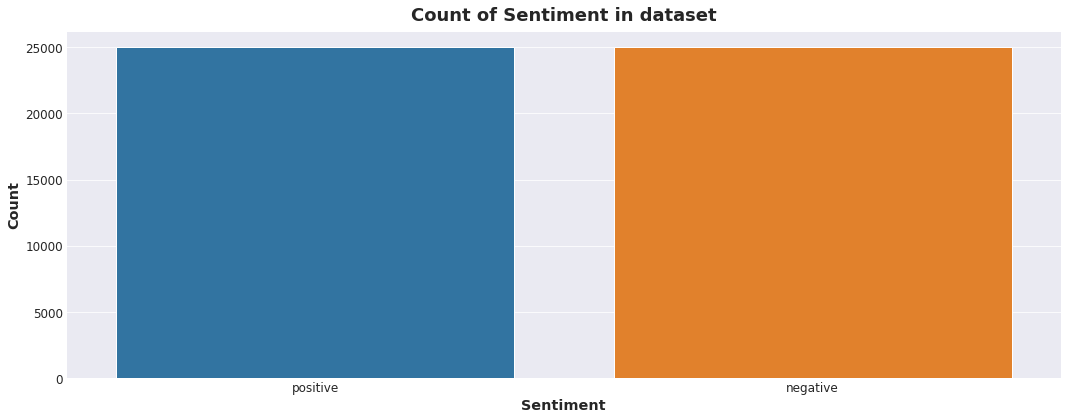

In [11]:
fig, ax = plt.subplots(figsize=(15,6))
sns.countplot(data=data, x="sentiment")
ax.set(title='Count of Sentiment in dataset', xlabel='Sentiment', ylabel='Count')
plt.show()

Visualize the average number of words per row

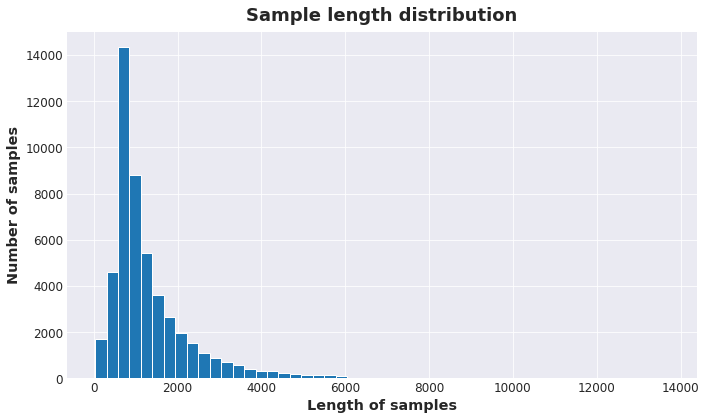

In [12]:
# Now, let's see the average number of words per sample
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(data['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

Encode the Labels for seniment column

In [ ]:
# Lets encode labels: each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.
label_encoder = preprocessing.LabelEncoder()
data['sentiment'] = label_encoder.fit_transform(data['sentiment'])
data.head()

In [ ]:
print(label_encoder.classes_)

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25)

Check the Shape of Training and Testing data

In [16]:
data_count = [train_data.shape[0], test_data.shape[0]]
print(f'Number of records for Training : {data_count[0]}')
print(f'Number of records for Testing : {data_count[1]}')
print(f'Shape : {train_data.shape}')

Number of records for Training : 37500
Number of records for Testing : 12500
Shape : (37500, 2)


In [17]:
train_data.head()

,review,sentiment
43676,"Follow the Fleet, an RKO production in 1936, s...",1
22771,"Even after all these years, this remain ""a per...",1
7380,"Better than the typical made-for-tv movie, INV...",1
574,Do you ever wonder what is the worst movie eve...,0
25453,this is the first time I'm writing a comment o...,0


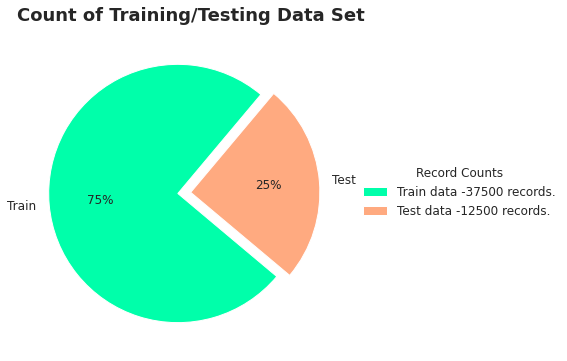

In [18]:
fig, ax = plt.subplots(figsize=(8,12))
wedges, texts, autotexts = ax.pie(x=[data_count[0], data_count[1]]
                                  , labels=['Train', 'Test']
                                  , explode=(0.1,0)
                                  , autopct='%1.0f%%' # Autopct formats our values as strings with a set number of decimal points.
                                  , colors=['#00ffaa', '#ffaa80']
                                  , startangle=50 )

_ = ax.set_title("Count of Training/Testing Data Set")
_ = ax.legend(frameon=False)

# for i, a in enumerate(text):
#   a.set_text(f"{data_count[i]}")
ax.legend(wedges, [f'Train data -{data_count[0]} records.', f'Test data -{data_count[1]} records.'],
          title="Record Counts",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
# plt.setp(autotexts, size=8, weight="bold")

plt.show()

## Step 3 : Data pre-processing

We can use a pre-trained text embedding as the first layer, which will have two advantages:

- we don't have to worry about text preprocessing,
- we can benefit from transfer learning.

In [19]:
import tensorflow_hub as hub
# Use the pre-trained embedding layer
hub_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(hub_url)

# View the output of embedded layer
embeddings = embed(train_data["review"])
print(embeddings.shape, embeddings.dtype)

(37500, 128) <dtype: 'float32'>


#### Create Train and Test data

In [20]:
X_train, y_train, X_test, y_test = embed(train_data["review"]), tf.convert_to_tensor(train_data.sentiment, dtype=tf.int32), embed(test_data["review"]), tf.convert_to_tensor(test_data.sentiment, dtype=tf.int32)

In [21]:
print(X_train.shape, y_train.shape)

(37500, 128) (37500,)


## Step 4: Building an Artificial Neural Network
Define a Model of atleast 4 Layers

Layer hyper-parameters:
- number of units/neurons: 128
- activation function: ReLU
- input_shape: (128, )
- Regularization : L2

### Adding layer with Dropout at last

Dropout is a Regularization technique where we randomly set neurons in a layer to zero. That way while training those neurons won't be updated. Because some percentage of neurons won't be updated the whole training process is long and we have less chance for overfitting.

<u>**It has been observed the best performance is achieved by adding it at the last layer. The experiments done to infer this is shown at the end of the notebook.**</u>

### No. of Units
No. of units kept to 128 to compensate the dropout layer and for better learning

In [22]:
tf.keras.backend.clear_session()

In [23]:
def model_build(num_layers=4, l2_regularizer=True, dropout_position=3):
  """ 
  Method to build a Model for given inputs 
  return : Returns the Sequential model built for given inputs
  """
  regularizer=None
  num_units = 64
  input_shape  = [128]

  if l2_regularizer:
    regularizer = tf.keras.regularizers.L2(0.01)

  # Build a sequential Model
  model = Sequential()
  print(f'Number of Layers : {num_layers+2}')
  for i in range(num_layers):
    # model.add(layers.BatchNormalization())
    # Add input shape to the first layer
    if i==0 :
      model.add(layers.Dense(num_units, input_shape=input_shape, activation='relu',
                          kernel_regularizer=regularizer, 
                          activity_regularizer=regularizer
                          ))  
    else :
      model.add(layers.Dense(num_units, activation='relu',
                            kernel_regularizer=regularizer, 
                            activity_regularizer=regularizer))
    
    # Add dropout after the Dense layer at given position
    if i==dropout_position :
      model.add(layers.Dropout(0.2))


  # Adding the output layer
  #   units: number of classes (10 in the Fashion MNIST dataset)
  #   activation: softmax
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  return model

In [24]:
# Build a model for given number of layers
l2_model = model_build() # Use defaults as they have the best settings
l2_model.layers

Number of Layers : 6
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_______________________________

## Step 5: Model Compilation
- Optimizer: **Adam** : <br>Adam is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.
- Loss: **Sparse softmax (categorical) crossentropy** : <br>Cross-entropy is the default loss function to use for multi-class classification problems
- Learning rate : kept as Default(0.001) as it gave better results in Training and testing<br>If your learning rate is set too low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function

In [25]:
opt = Adam()
l2_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

## Step 6: Model Training


Rather than iterating with different Epochs we can add an early-stopping to prevent the overfitting of Model. 

A callback is just a function you want run every so ofter while the network trains. The early stopping callback will run after every epoch.

After defining the callback, add it as an argument in fit (you can have several, so put it in a list). Choose a large number of epochs when using early stopping, more than you'll need.

In [26]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [27]:
def loss_acc_plot(df, batch_size=None):
  """
  Method to plot the Loss and Accurracy with the given History dataframe as input
  """
  # evaluate the model
  train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
  print("----------------------------------------------------------")
  print("\t          | Train | Test")  
  print("----------------------------------------------------------")
  print(f"\tLoss      | {train_loss:.3f} | {test_loss:.3f}")  
  print(f"\tAccurracy | {train_loss:.3f} | {test_loss:.3f}")  
  print("----------------------------------------------------------")
  # plot loss during training
  fig, ax = plt.subplots(ncols=2, figsize=(12,6))
  fig.suptitle(f'Loss and Accurracy Graph\nBatch size {batch_size}', size=15)
  # plt.subplot(211)
  ax[0].set_title('Loss')
  ax[0].plot(df['loss'], label='train')
  ax[0].plot(df['val_loss'], label='test')
  ax[0].legend()
  # plot mse during training
  ax[1].set_title('Accurracy')
  ax[1].plot(df['accuracy'], label='train')
  ax[1].plot(df['val_accuracy'], label='test')
  ax[1].legend()
  plt.show()

def loss_acc_plot(df, train_loss, train_accuracy, test_loss
                  , test_accuracy, batch_size=None):
  """
  Method to plot the Loss and Accurracy with the given History dataframe as input
  """
  print("----------------------------------------------------------")
  print("\t          | Train | Test")  
  print("----------------------------------------------------------")
  print(f"\tLoss      | {train_loss:.3f} | {test_loss:.3f}")  
  print(f"\tAccurracy | {train_accuracy:.3f} | {test_accuracy:.3f}")  
  print("----------------------------------------------------------")
  # plot loss during training
  fig, ax = plt.subplots(ncols=2, figsize=(12,6))
  fig.suptitle(f'Loss and Accurracy Graph\nBatch size {batch_size}', size=15)
  # plt.subplot(211)
  ax[0].set_title('Loss')
  ax[0].plot(df['loss'], label='train')
  ax[0].plot(df['val_loss'], label='test')
  ax[0].legend()
  # plot mse during training
  ax[1].set_title('Accurracy')
  ax[1].plot(df['accuracy'], label='train')
  ax[1].plot(df['val_accuracy'], label='test')
  ax[1].legend()
  plt.show()

# Method to train a model
from time import perf_counter
def train_model(model, batch_size):
  """
  This method will train the model for given batch_size
  """
  t_start = perf_counter()
  history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test), 
    batch_size=batch_size, epochs=300,
    callbacks=[early_stopping],
    verbose=0
    )
  train_time  = perf_counter() - t_start
  print("\n")
  print(f"Time taken for training : {train_time:0.2f} seconds. Batch size : {batch_size}")
  # Evaulate the model
  train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
  test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
  # Store results in data frame
  history_df = pd.DataFrame(history.history)
  history_df.head()
  # Plot the loss and accuraccy graph
  loss_acc_plot(history_df, train_loss, train_accuracy
                , test_loss, test_accuracy, batch_size)
  return [train_time, train_loss, train_accuracy, test_loss, test_accuracy]

def train_for_batches(model, start_batch_size=32):
  """ 
  This Method will train the model for different batch sizes and will 
  print their Loss and Accurracy graph
  return : Dataframe with metrics for each batch_size 
  """
  # List of batch size(in steps of 32) for testing of loss and accurracy
  batch_sizes = [x for x in range(start_batch_size,150,32)]
  eval_df_cols = ['train_time','loss','accurracy', 'val_loss', 'val_accurracy']
  eval_df = pd.DataFrame(index=batch_sizes, columns=eval_df_cols)
  # Train model with various batch size and view the performance
  for batch_size in batch_sizes:
    result = train_model(model=model, batch_size=batch_size)
    eval_df.loc[batch_size] = result
  
  return eval_df

### Train the Model for **various batch Sizes** and compare their loss and accurracy



Time taken for training : 91.41 seconds. Batch size : 32
----------------------------------------------------------
	          | Train | Test
----------------------------------------------------------
	Loss      | 0.472 | 0.472
	Accurracy | 0.798 | 0.800
----------------------------------------------------------


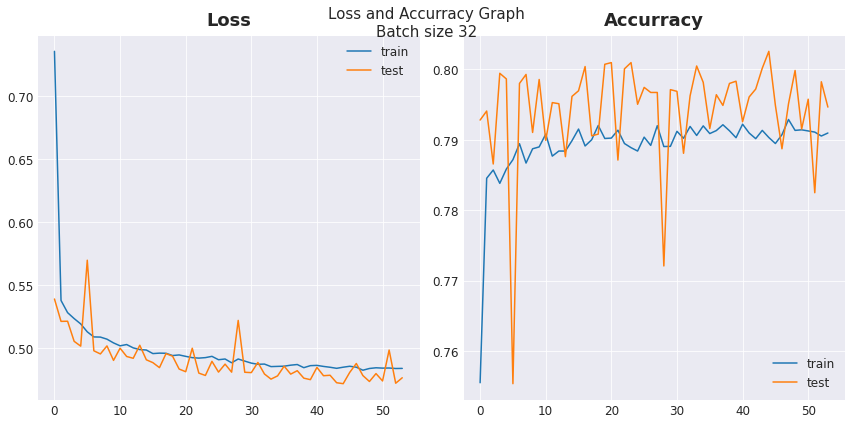



Time taken for training : 11.36 seconds. Batch size : 64
----------------------------------------------------------
	          | Train | Test
----------------------------------------------------------
	Loss      | 0.469 | 0.470
	Accurracy | 0.799 | 0.801
----------------------------------------------------------


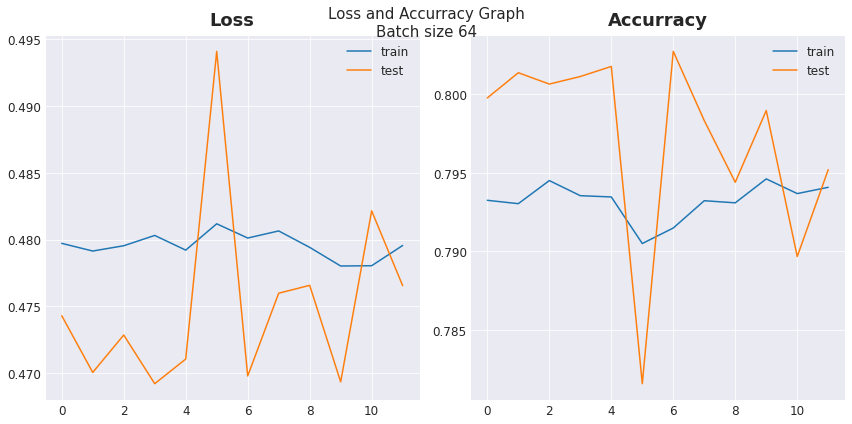



Time taken for training : 16.08 seconds. Batch size : 96
----------------------------------------------------------
	          | Train | Test
----------------------------------------------------------
	Loss      | 0.465 | 0.468
	Accurracy | 0.801 | 0.802
----------------------------------------------------------


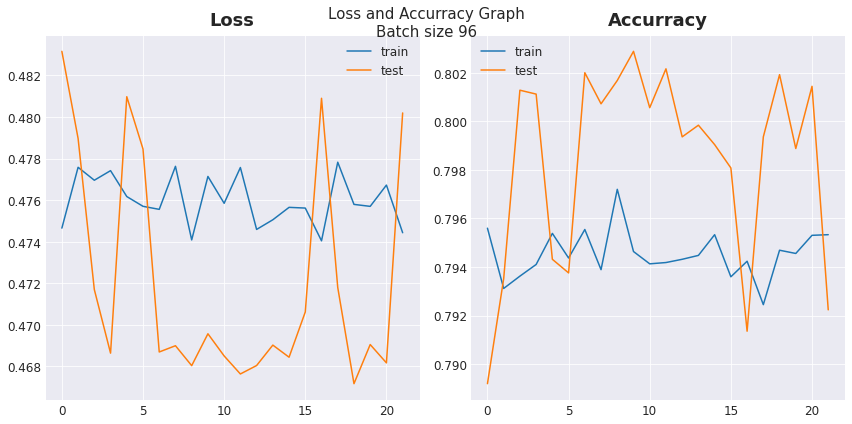



Time taken for training : 15.87 seconds. Batch size : 128
----------------------------------------------------------
	          | Train | Test
----------------------------------------------------------
	Loss      | 0.463 | 0.466
	Accurracy | 0.801 | 0.803
----------------------------------------------------------


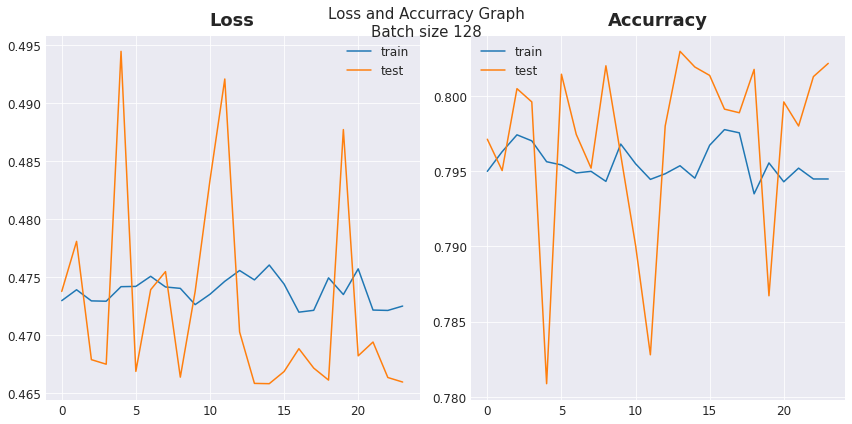

In [28]:
eval_df = train_for_batches(l2_model, 32)

### Training time reduces with Larget batch size, also slight improvement in Loss and accurracy with Regularization as L2

In [29]:
eval_df

,train_time,loss,accurracy,val_loss,val_accurracy
32,91.4103,0.471806,0.79824,0.47219,0.80016
64,11.3613,0.469373,0.799227,0.47005,0.80136
96,16.0846,0.465121,0.801013,0.46764,0.80216
128,15.8682,0.462602,0.801413,0.465842,0.80296


## Step 7: Model Evaluation

Number of Layers : 6
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_88 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_89 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_90 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
____________________________

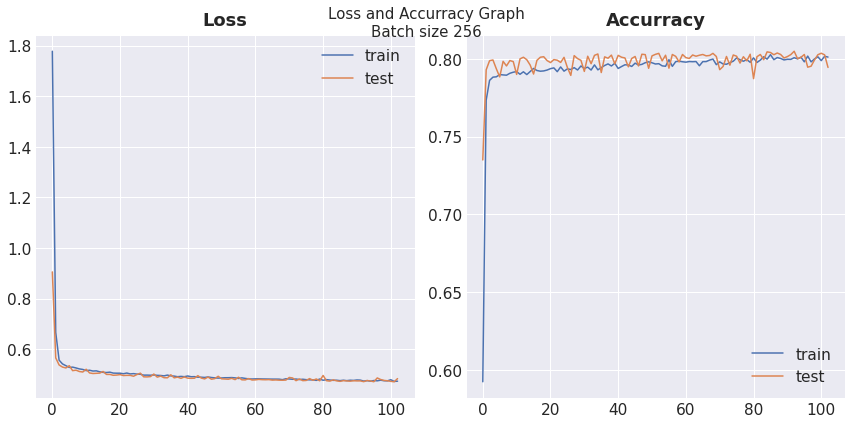

In [54]:
# Let's rebuild the Model with best parameters
model = model_build()
opt = Adam()
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(model, 256)

#### Classification Report

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test/Validation accuracy: {test_accuracy:.3f}")
print (classification_report(y_test, y_pred_classes))

391/391 [==============================] - 0s 865us/step - loss: 0.4720 - accuracy: 0.8048
Test/Validation accuracy: 0.805
              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6325
           1       0.81      0.79      0.80      6175

    accuracy                           0.80     12500
   macro avg       0.80      0.80      0.80     12500
weighted avg       0.80      0.80      0.80     12500



#### Confusion Matrix

In [60]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """    
    data = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(data, columns=classes, index = classes).astype('float')
    
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (12,8))
    plt.title(title, color='green', fontsize=25)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color='indigo')
    plt.yticks(tick_marks, classes, color='indigo')
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, cmap="YlGnBu", annot=True, annot_kws={"size": 16}, fmt=".0f")
    # plt.imshow(df_cm, interpolation='nearest', cmap="YlGnBu")
    plt.tight_layout()
    plt.ylabel('Actual', color='crimson', fontsize=20)
    plt.xlabel('Predicted', color='crimson', fontsize=20)

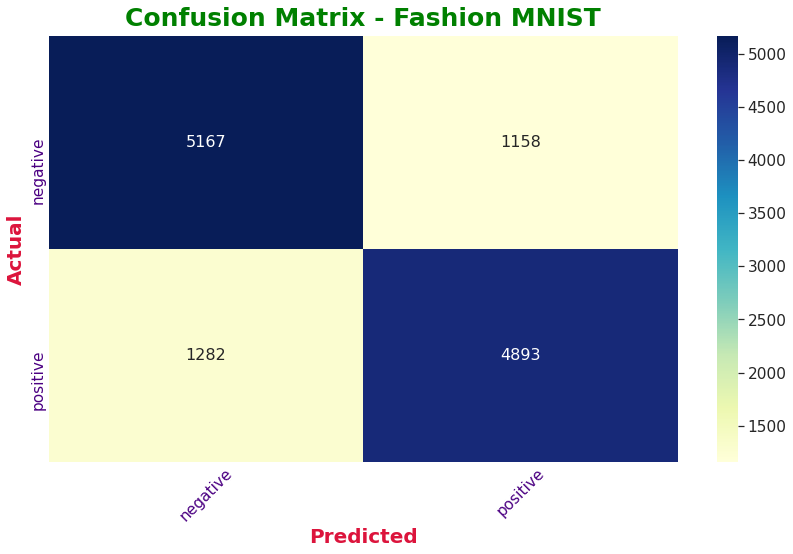

In [61]:
plot_confusion_matrix(y_test, y_pred_classes, ['negative', 'positive'], title="Confusion Matrix - Fashion MNIST")

### Summary
Maximum no. of correct prediction was given for negative class

Maximum no. of wrong predictions were made for negative class

#### Model Comparision
The best result was given by Model with layers = 6, Optimizer=Adam, learning_rate = 0.001, batch_size=256 and Dropout layer at the last 

The worst result was given by Model with layers = 6, Optimizer=Adam, learning_rate=0.01, batch_size=64 and Dropout layer in the middle


## Model without regularization
Regularization is a technique which makes slight modifications to the learning algorithm by penalizing the weight matrices such that the model generalizes better. This in turn improves the model’s performance on the unseen data as well.


#### We can see smoothness in the Plot without regularization as no penaly is being imposed and avoids overfitting.

#### We can also observe Training accuraccy is higher than the validation/Test accurracy



Number of Layers : 5
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


Time taken for training : 9.55 seconds. Batch size : 128
------------------------------------

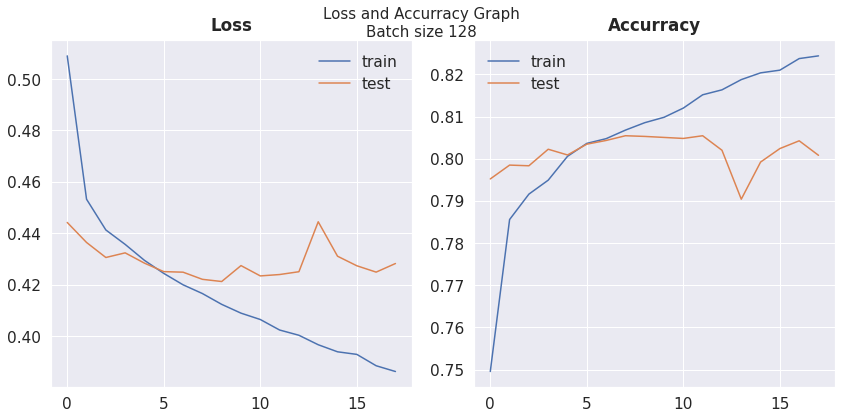

In [36]:
wo_l2_model = model_build(num_layers=3, l2_regularizer=False, dropout_position=0)
opt = Adam()
wo_l2_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(wo_l2_model, batch_size=128)

## Changing dropout position


#### We can see the dropout layer placed in the end gave the best performance and one in the middle gave the worst performance



Number of Layers : 6
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_____________________________

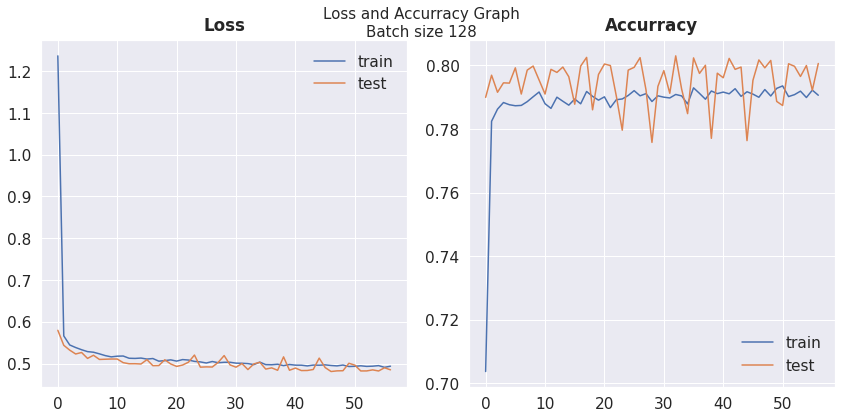

In [37]:
# Model with Dropout layer after First dense layer
l2_model_40 = model_build(num_layers=4, l2_regularizer=True, dropout_position=0)
l2_model_40.layers
l2_model_40.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(l2_model_40, 128)

Number of Layers : 6
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_____________________________

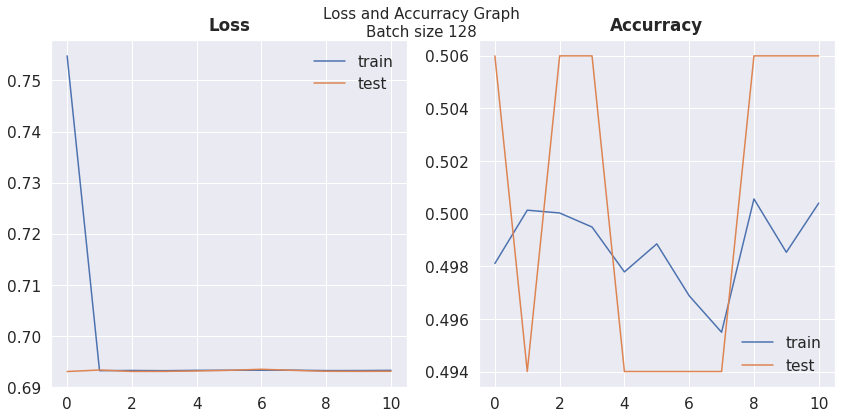

In [38]:
# Model with Dropout layer after second dense layer
l2_model_41 = model_build(num_layers=4, l2_regularizer=True, dropout_position=1)
l2_model_41.layers
opt = Adam(lr=0.01)
l2_model_41.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(l2_model_41, 128)

Number of Layers : 6
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_____________________________

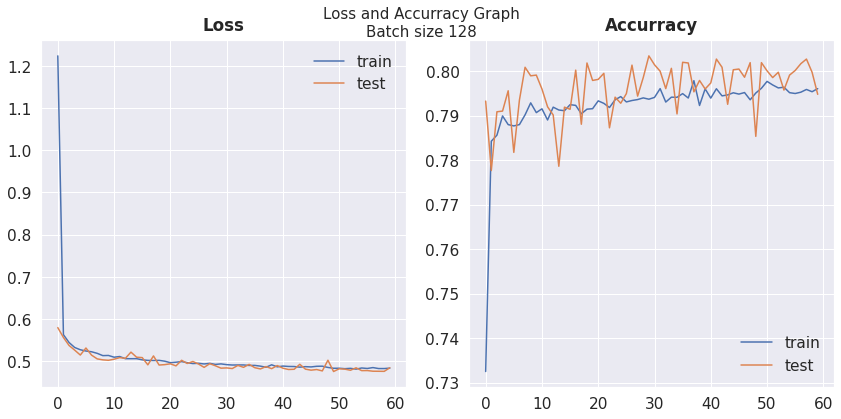

In [39]:
# Model with Dropout layer after Third dense layer
l2_model_42 = model_build(num_layers=4, l2_regularizer=True, dropout_position=2)
l2_model_42.layers
opt = Adam(lr=0.001)
l2_model_42.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(l2_model_42, 128)

Number of Layers : 6
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 65        
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_____________________________

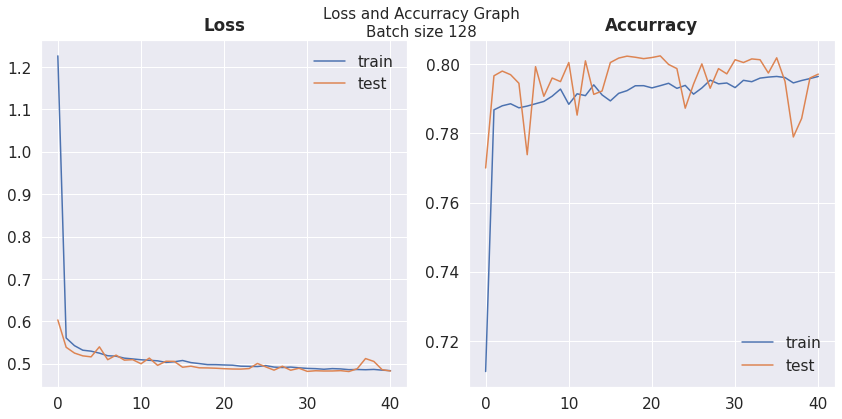

In [40]:
# Model with Dropout layer after Fourth dense layer
l2_model_42 = model_build(num_layers=4, l2_regularizer=True, dropout_position=3)
l2_model_42.layers
opt = Adam(lr=0.001)
l2_model_42.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(l2_model_42, 128)

### Changing Optimizer
If your learning rate is set too low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function

Let's compare and SGD Optimizer with the Adam for the same set of Hyperparameters. **Adam has performed slighly better**

Number of Layers : 5
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_67 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_68 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


Time taken for training : 24.79 seconds. Batch size : 128
----------------------------------

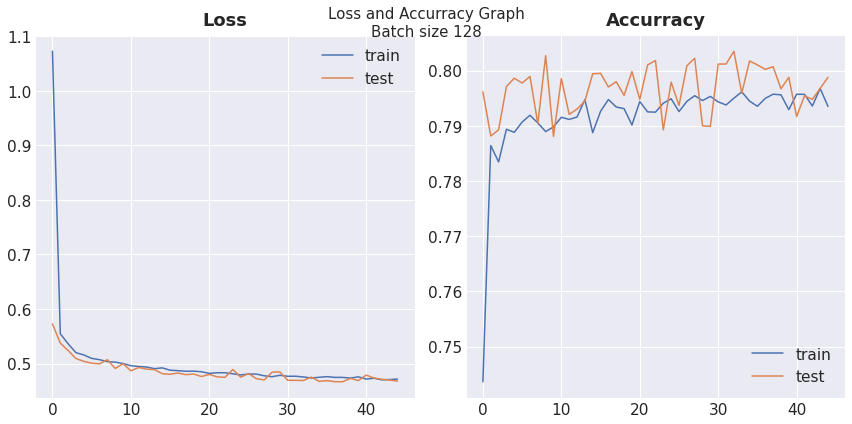

In [48]:
adam_l2_model = model_build(num_layers=3, l2_regularizer=True, dropout_position=2)
opt = Adam(lr=0.001)
adam_l2_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(adam_l2_model, 128)

Number of Layers : 5
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_71 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


Time taken for training : 137.81 seconds. Batch size : 128
---------------------------------

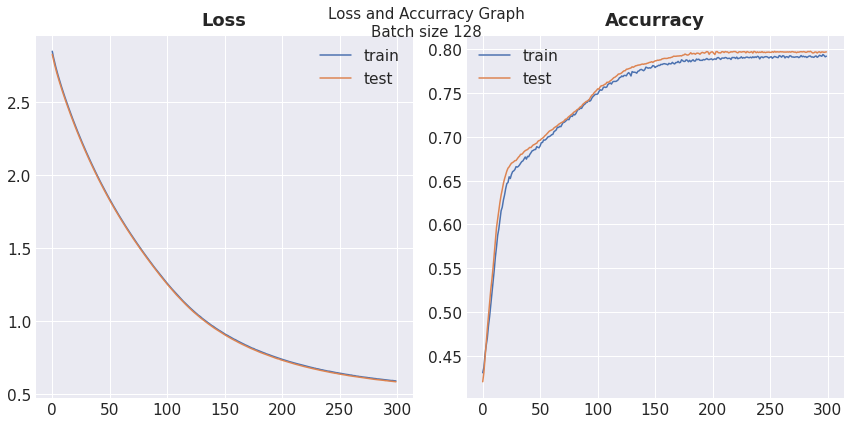

In [49]:
sgd_l2_model_1 = model_build(num_layers=3, l2_regularizer=True, dropout_position=2)
opt = SGD(lr=0.001)
sgd_l2_model_1.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(sgd_l2_model_1, 128)

Number of Layers : 5
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_79 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_80 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


Time taken for training : 16.70 seconds. Batch size : 128
----------------------------------

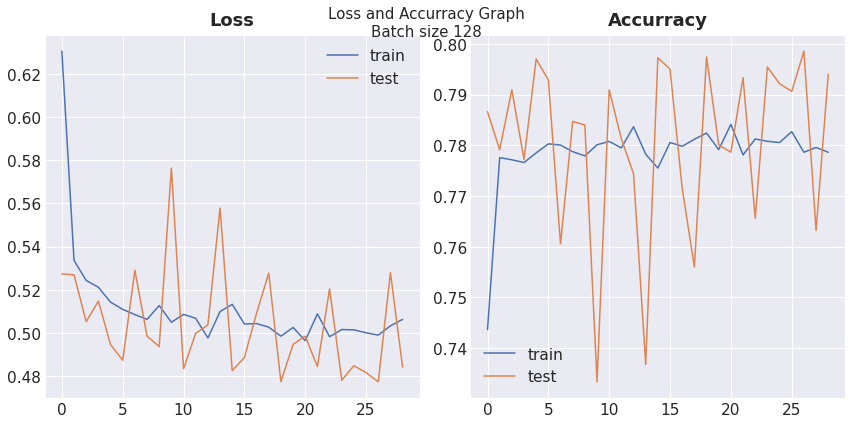

In [51]:
adam_l2_model = model_build(num_layers=3, l2_regularizer=True, dropout_position=2)
opt = Adam(lr=0.01)
adam_l2_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
result = train_model(adam_l2_model, 128)